In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
counties = gpd.read_file("OSMB-46184682c1a71852b4f335f9ce651d8857373220.geojson")
counties = counties.loc[counties["admin_level"] == 6] #there are two townships in here for some reason
counties = counties.to_crs(6551)

In [4]:
urban_areas = gpd.read_file("tl_2020_us_uac20/tl_2020_us_uac20.shp")
urban_areas = urban_areas.to_crs(6551)

In [5]:
from sqlalchemy import create_engine
con = create_engine("postgresql://localhost/osm_midwest")  

In [6]:
water = gpd.read_postgis("""
     SELECT 
         way, way_area
     FROM 
         planet_osm_polygon as p
     WHERE 
             (p.natural = "water" OR p.natural='wetland' OR p.natural='bay'
              OR p.landuse='reservoir' OR p.landuse='basin' 
              OR p.water is not null OR p.waterway is not null) 
          AND
              p.way_area > 1e6
    """, con, geom_col='way')  
water = water.to_crs(6551)
water = water.loc[water.intersects(counties.unary_union)]

In [7]:
water_lines = gpd.read_postgis("""
     SELECT 
         *
     FROM 
         planet_osm_line as l
     WHERE 
         l.waterway is not null
    """, con, geom_col='way')  
water_lines = water_lines.to_crs(6551)
water_lines = water_lines.loc[water_lines.intersects(counties.unary_union)]

In [8]:
highways = gpd.read_postgis("""
SELECT 
    highway, way
FROM 
    planet_osm_roads as r
WHERE
    r.highway in ('motorway', 'motorway_link', 'platform', 'primary', 'primary_link', 'secondary', 'secondary_link', 'trunk')
""", con, geom_col="way")
highways = highways.to_crs(6551)

In [9]:
def render_map(bound):
    
    base = bound.plot(ec="k", fc="#b1d8b8")
    
    base = water.clip(bound).way.plot(ax=base)
    
    w_lines = water_lines.clip(bound)
    w_lines.loc[w_lines.waterway == "river"].plot(ax=base, lw=2)
    
    urban_areas.clip(bound).plot(ax=base, color="#f1f1f1")
        
    h = highways.clip(bound)
    for lw, kinds in [(2, ["primary"]), 
                      (1, ["trunk", "primary_link", "motorway", "secondary", "secondary_link"])]:
        h.loc[h.highway.isin(kinds)].plot(ax=base, lw=lw, color="grey")
    bound.plot(ax=base, ec="k", fc="none", zorder=100)
    base.set_axis_off()
    return base
   

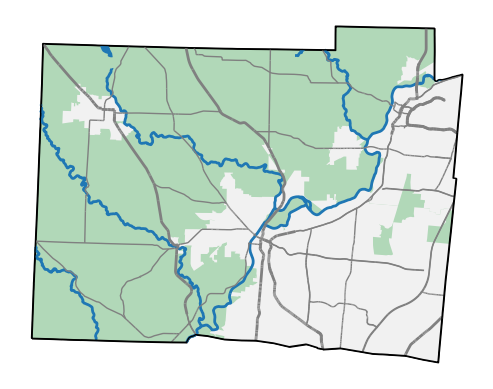

In [10]:
ax = render_map(counties.sample(1))

In [11]:
for name in counties.name:
    ax = render_map(counties.loc[counties.name == name])
    plt.savefig(f"plots/{name.split()[0]}.png", bbox_inches="tight", transparent="true")
    plt.close()

/Users/wheeler.883/brew/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/wheeler.883/brew/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/wheeler.883/brew/lib/python3.10/site-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/wheeler.883/brew/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/wheeler.883/brew/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/wheeler.883/brew/lib/python3.10/site

In [12]:
for name, centroid in zip(counties.name, counties.centroid):
    print(f"\"{name.split()[0]}\": [{centroid.x/5280.0}, {centroid.y/5280.0}],")

"Paulding": [264.2338502823101, 216.27422136834133],
"Wood": [314.39418539311765, 232.3001318944496],
"Mahoning": [462.93876026591073, 208.84677175754624],
"Meigs": [398.475357745453, 74.7312943378924],
"Summit": [423.3399821526124, 215.92924993497144],
"Richland": [370.9144362792145, 191.40516646361215],
"Vinton": [373.6112187472688, 86.2964926036159],
"Pike": [342.34420099911466, 74.42511169053239],
"Miami": [281.16339855269115, 142.51715534230112],
"Tuscarawas": [426.92682067004284, 168.68598477455458],
"Wayne": [404.9104635641015, 195.26338428465738],
"Sandusky": [339.31860058617025, 231.76716232673164],
"Morgan": [407.34147433247136, 111.89217449936596],
"Putnam": [287.5220487819108, 209.27768695754014],
"Noble": [428.42114911308374, 122.12355217366024],
"Trumbull": [463.32125131362045, 229.7242844241244],
"Stark": [432.30226841110306, 194.50457721161624],
"Seneca": [340.0513893476322, 215.64231343475268],
"Wyandot": [330.6577025049149, 196.2753189750357],
"Van": [263.507028930743